In [19]:
from scipy import stats
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

np.random.seed(seed=999)

In [20]:
X = [np.ndarray] * 4
X[0] = stats.chi2(2).rvs(size=100)
X[1] = stats.norm(3, 1).rvs(size=150)
X[2] = stats.uniform(-2, 4).rvs(size=200)
X[3] = stats.norm(5, 1).rvs(size=100)
pooled = np.concatenate(X)

In [24]:
res = pd.DataFrame(index=[f'X{i + 1}' for i in range(len(X))] + ["Pooled"], columns = ["mean", "var", "std"])
for i in range(len(X) + 1):
    if i == len(X):
        res.loc['Pooled', :] = [pooled.mean(), pooled.var(), pooled.std()]
    else:
        res.loc[f'X{i + 1}', :] = [X[i].mean(), X[i].var(), X[i].std()]
        
res

,mean,var,std
X1,2.358265,5.550881,2.356031
X2,2.983326,0.945666,0.972454
X3,-0.11176,1.251382,1.118652
X4,4.812581,1.030817,1.015292
Pooled,2.076784,5.250719,2.291445


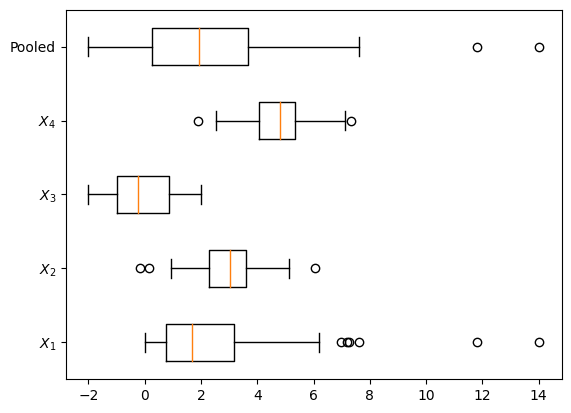

In [37]:
_ = plt.boxplot(X + [pooled], vert=False, labels=[f"$X_{i + 1}$" for i in range(len(X))] + ["Pooled"])

In [38]:
res = stats.bartlett(*X)
print(f"stat: {res.statistic}, pvalue: {res.pvalue}")

stat: 143.7448595642775, pvalue: 5.88744606272854e-31
